<a href="https://colab.research.google.com/github/threegenie/knn_project/blob/main/new_work_times_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 그래프 한글 깨짐 방지

In [1]:
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use("ggplot")
plt.rc('font', family='Malgun Gothic')

### 데이터 불러오기

In [2]:
import pandas as pd
import os, sys
import numpy as np

df = pd.read_csv('동화데이터_최종.csv')

In [3]:
df.head()

,제목,내용,카테고리,키워드,테마
0,고양이와 쥐의 파트너십(동반자관계),쥐를 친구로 된 어떤 고양이가 살고 있었다. \r\n고양이는 자신이 쥐에 대해 사랑...,그림형제동화,"['고양이', '돼지 비계', '이름', '항아리', '세례', '대모', '친구'...",교회
1,건달들의 무리,하루는 수탉이 암탉에게 말했다. \r\n“나무열매들이 익어 가는 계절이 왔는데 슬슬...,그림형제동화,"['수탉', '암탉', '오리', '나그네', '주막 주인', '마차']",숲속
2,실 잣는 세 여인네들,옛날 옛적에 게을러서 실을 잣지 않으려는 소녀가 한 명 있었어요.\r\n엄마가 뭐라...,그림형제동화,"['소녀', '엄마', '왕비', '게으름', '세여인']",왕국
3,"지푸라기, 숯, 콩",옛날 어느 마을에 가난한 노파가 한 명 살고 있었어요.\r\n그녀는 접시에 콩들을 ...,그림형제동화,"['숯', '지푸라기', '콩', '탈출', '재봉사', '도움']",마을
4,"생쥐, 새, 소시지",옛날 어느 날 생쥐와 새와 ‘소시지’가 동무가 되어 한 집에서 살게 되었어요.\r\...,그림형제동화,"['소시지', '생쥐', '새', '뗄감', '요리', '후회']",숲속


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      442 non-null    object
 1   내용      442 non-null    object
 2   카테고리    442 non-null    object
 3   키워드     442 non-null    object
 4   테마      442 non-null    object
dtypes: object(5)
memory usage: 17.4+ KB


#### 불용어 제거 및 형태소 분석

In [5]:
!pip install squarify

In [6]:
import re
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer

#### 불용어 파일 읽어오기

In [7]:
dft = pd.read_table('불용어.txt')
df_dict = dft.to_dict()
st_words = list(df_dict[dft.columns[0]].values())

#### tokenize_test 함수로 내용을 토큰화하여 저장하기

In [9]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 33.0 MB/s eta 0:00:00


In [10]:
from konlpy.tag import Okt
import re

# Okt 객체 생성
okt = Okt()

# 불용어 리스트
st_words = list(set(st_words))

def tokenize_test(text):
    # 줄바꿈 제거
    text = text.replace("\n", " ")

    # 한글, 숫자, 공백을 제외한 모든 문자 제거
    replace = ""
    pattern = "[^가-힣0-9 ]"
    doc = re.sub(pattern, replace, text)

    tokens = []

    # 내용 중에서 명사만 tokens 변수에 저장하기
    for word in okt.nouns(doc):
        tokens.append(word)
    return tokens

# 테스트
text = "안녕하세요. 자연어 처리를 공부하고 있습니다. 이 예제는 형태소 분석과 토큰화 예제입니다."
print(tokenize_test(text))

['자연어', '처리', '공부', '이', '예제', '형태소', '분석', '토큰', '예제']


In [11]:
df['Tokens']=df['내용'].apply(tokenize_test)
df['Tokens']

0      [쥐, 친구, 고양이, 살, 고양이, 자신, 쥐, 대해, 사랑, 우정, 말, 쥐, ...
1      [하루, 수탉, 암탉, 말, 나무, 열매, 계절, 슬슬, 언덕, 배, 잔뜩, 다람쥐...
2      [옛날, 옛적, 실, 잣, 소녀, 명, 엄마, 소녀, 꿈쩍, 안, 엄마, 화가, 나...
3      [옛날, 마을, 노파, 명, 살, 그녀, 접시, 콩, 요리, 해, 불, 활활, 다음...
4      [옛날, 날, 생쥐, 새, 소시지, 동무, 집, 살, 서로, 의지, 재산, 새, 일...
                             ...                        
437    [옛날, 옛적, 장가, 못, 나무꾼, 하루, 나무, 산, 사냥꾼, 노루, 발견, 노...
438    [옛날, 마을, 나무꾼, 나무꾼, 성품, 나무꾼, 나무꾼, 매일, 나무, 일, 날,...
439    [옛날, 마을, 심, 봉사, 장님, 심청, 딸, 심청, 장님, 아버지, 위해, 돈,...
440    [옛날, 선비, 과거, 를, 가기, 위해, 산, 오르다, 구렁이, 새끼, 까치, 발...
441    [흥부전, 작자, 연대, 미상, 소설, 조선, 후기, 소설, 흥, 보전, 박흥, 보...
Name: Tokens, Length: 442, dtype: object

#### 단어 빈도 정보를 df로 만들기

In [12]:
def word_count(docs):

    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    # 기존에 누적으로 업데이트하기
    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    # 합치기
    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')

    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

#### 각 단어별로 수 세기

In [13]:
from collections import Counter
word_counts = Counter()
df['Tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('그', 1832),
 ('말', 1480),
 ('것', 618),
 ('이', 569),
 ('수', 525),
 ('사람', 470),
 ('자신', 468),
 ('내', 425),
 ('집', 388),
 ('거', 329)]

In [14]:
wc = word_count(df['Tokens'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
165,그,351,1832,1.0,0.032035,0.032035,0.794118
177,말,368,1480,2.0,0.025880,0.057914,0.832579
119,것,204,618,3.0,0.010806,0.068721,0.461538
163,이,235,569,4.0,0.009950,0.078670,0.531674
83,수,239,525,5.0,0.009180,0.087851,0.540724
549,사람,180,470,6.0,0.008219,0.096069,0.407240
170,자신,238,468,7.0,0.008184,0.104253,0.538462
171,내,187,425,8.0,0.007432,0.111684,0.423077
164,집,140,388,9.0,0.006785,0.118469,0.316742
172,거,176,329,10.0,0.005753,0.124222,0.398190


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44163 (\N{HANGUL SYLLABLE GEOS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

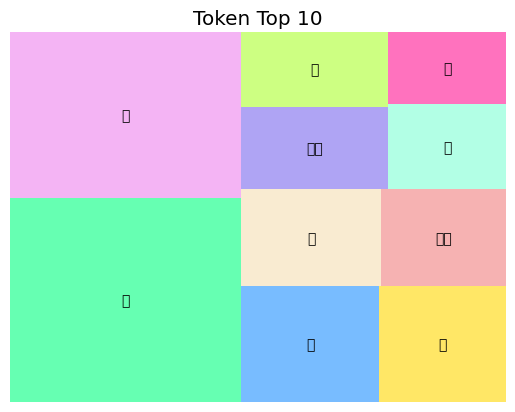

In [15]:
import squarify
import matplotlib.pyplot as plt

colors=['springgreen','violet','dodgerblue','gold','wheat','lightcoral',
        'mediumslateblue','greenyellow','aquamarine','deeppink']

wc_top5 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top5['percent'], label=wc_top5['word'], alpha=0.6, color=colors)
plt.axis('off')
plt.title('Token Top 10')
plt.show()

In [16]:
wc_top5['word']

165     그
177     말
119     것
163     이
83      수
549    사람
170    자신
171     내
164     집
172     거
Name: word, dtype: object

In [17]:
# pip install wordcloud

In [18]:
from wordcloud import WordCloud
# 추가할 불용어를 리스트 형태로 추가함.

In [19]:
df['Tokens']

0      [쥐, 친구, 고양이, 살, 고양이, 자신, 쥐, 대해, 사랑, 우정, 말, 쥐, ...
1      [하루, 수탉, 암탉, 말, 나무, 열매, 계절, 슬슬, 언덕, 배, 잔뜩, 다람쥐...
2      [옛날, 옛적, 실, 잣, 소녀, 명, 엄마, 소녀, 꿈쩍, 안, 엄마, 화가, 나...
3      [옛날, 마을, 노파, 명, 살, 그녀, 접시, 콩, 요리, 해, 불, 활활, 다음...
4      [옛날, 날, 생쥐, 새, 소시지, 동무, 집, 살, 서로, 의지, 재산, 새, 일...
                             ...                        
437    [옛날, 옛적, 장가, 못, 나무꾼, 하루, 나무, 산, 사냥꾼, 노루, 발견, 노...
438    [옛날, 마을, 나무꾼, 나무꾼, 성품, 나무꾼, 나무꾼, 매일, 나무, 일, 날,...
439    [옛날, 마을, 심, 봉사, 장님, 심청, 딸, 심청, 장님, 아버지, 위해, 돈,...
440    [옛날, 선비, 과거, 를, 가기, 위해, 산, 오르다, 구렁이, 새끼, 까치, 발...
441    [흥부전, 작자, 연대, 미상, 소설, 조선, 후기, 소설, 흥, 보전, 박흥, 보...
Name: Tokens, Length: 442, dtype: object

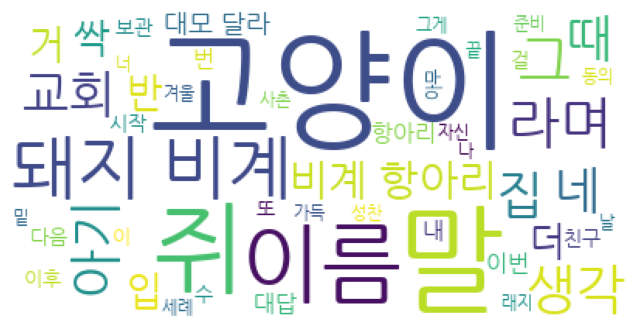

In [20]:
# 워드 클라우드 세팅
# 한글폰트 경로 설정
wc = WordCloud (max_words=50,
           random_state= 810,
           background_color='white',
           font_path= 'NanumGothic.ttf'#
           )


text = df['Tokens'][0]
text = ' '.join(text)

wc.generate_from_text(text)
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

## KNN + TfidVectorizer

In [22]:
# print(sorted(st_words))

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=st_words
                        ,tokenizer=tokenize_test
                        ,ngram_range = (1,2)
                        ,max_features = 5000,
                        token_pattern=None
                        )

dtm = tfidf.fit_transform(df['내용'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['각하', '간', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '다시', '답', '대로', '대하', '대해', '더', '더욱이', '도달', '도착', '동시', '됏', '두번째', '뒤', '듯', '따름', '때문', '라면', '리하', '마자', '막론', '만', '만이', '만하', '말', '망정', '메', '몰랏다', '무릎', '바', '반대', '방면', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리', '비교', '뿐', '사람', '상대', '생각', '서술', '수', '시오', '시작', '시초', '아래', '아무', '안', '알', '알다', '앞', '어기', '어쨋', '어찌됏', '여보', '연관', '옆', '외', '요', '우', '위', '위해', '윗', '의거', '의지', '의치', '이로', '이서', '이외', '이용', '이유', '인', '일반', '일지', '임', '입', '입장', '적', '점', '정도', '제외', '젠', '종합', '주저', '줄', '중', '즈음', '지경', '진짜', '집', '쪽', '차', '첫', '토', '통', '편이', '하든', '하자', '한적', '함', '항목', '해', '해도', '향', '형식'

In [24]:
dtm.head()

,가게,가격,가기,가까이,가끔,가나,가난,가다가,가도,가득,...,흥부,희망,흰색,히죽,힐,힘,힘 감,힘 다해,힘 세고,힘껏
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.021001,0.027785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.052309,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.033081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree') #최근접 5이웃
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree')

In [26]:
result = nn.kneighbors([dtm.iloc[1]]) # 특정 행과 가장 유사한 문서 5개를 찾는다.
result

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.        , 1.2539936 , 1.27442984, 1.28604703, 1.29309653]]),
 array([[  1,  10, 264, 378, 140]]))

In [27]:
df.iloc[result[1][0]]

,제목,내용,카테고리,키워드,테마,Tokens
1,건달들의 무리,하루는 수탉이 암탉에게 말했다. \r\n“나무열매들이 익어 가는 계절이 왔는데 슬슬...,그림형제동화,"['수탉', '암탉', '오리', '나그네', '주막 주인', '마차']",숲속,"[하루, 수탉, 암탉, 말, 나무, 열매, 계절, 슬슬, 언덕, 배, 잔뜩, 다람쥐..."
10,코르베스 씨,옛날 옛적에 함께 드라이브를 나가고 싶어한 수탉과 암탉이 있었어요.\r\n그래서 수...,그림형제동화,"['닭', '고양이', '코르베스', '맷돌', '달걀', '오리', '핀', '바늘']",숲속,"[옛날, 옛적, 드라이브, 수탉, 암탉, 수탉, 마차, 수레바퀴, 네, 개, 마차,..."
264,개와 수탉과 여우,개와 수탉이 친구가 되어 함께 여행을 떠났답니다.\r\n밤이 되자 그들은 울창한 나...,이솝우화,"['개', '수탉', '여우', '친구', '나무']",숲속,"[개, 수탉, 친구, 여행, 밤, 그, 울창, 나무, 속, 곳, 마련, 수탉, 나무..."
378,좁쌀 한 톨,옛날 어느 산골 마을에 가난하지만 심지가 아주 굳은 총각이 살고 있었어요. 총각은 ...,전래동화,"['총각', '행운', '좁쌀', '황소', '고양이']",마을,"[옛날, 산골, 마을, 심지, 아주, 총각, 살, 총각, 글공부, 날, 과거, 한양..."
140,싸움닭들과 독수리,싸움닭 두 마리가 안마당의 주도권을 놓고 피 터지게 싸우고 있었어요.\r\n그러다 ...,이솝우화,"['수탉', '독수리', '주도권', '교만']",마당,"[싸움닭, 두, 마리, 안마당, 주도, 피, 마리, 다른, 마리, 힐, 수, 진, ..."


In [28]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
print(df['내용'].iloc[result[1][0]])

1      하루는 수탉이 암탉에게 말했다. \r\n“나무열매들이 익어 가는 계절이 왔는데 슬슬...
10     옛날 옛적에 함께 드라이브를 나가고 싶어한 수탉과 암탉이 있었어요.\r\n그래서 수...
264    개와 수탉이 친구가 되어 함께 여행을 떠났답니다.\r\n밤이 되자 그들은 울창한 나...
378    옛날 어느 산골 마을에 가난하지만 심지가 아주 굳은 총각이 살고 있었어요. 총각은 ...
140    싸움닭 두 마리가 안마당의 주도권을 놓고 피 터지게 싸우고 있었어요.\r\n그러다 ...
Name: 내용, dtype: object


- 특정 동화를 입력하면 유사한 동화를 출력

#### 특정 주제에 관한 동화들을 분류하는 모델 만들기 - 은혜에 대한 동화

**타겟 라벨 만들기**

In [29]:
for row in df['내용']:
  df['내용'] = df['내용'].str.lower()

In [30]:
target_label = df['내용'].str.contains('복수')
df['label'] = target_label

In [31]:
df['label'] = df['label'].astype(int)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      442 non-null    object
 1   내용      442 non-null    object
 2   카테고리    442 non-null    object
 3   키워드     442 non-null    object
 4   테마      442 non-null    object
 5   Tokens  442 non-null    object
 6   label   442 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 24.3+ KB


In [33]:
df['label'].value_counts()

label
0    428
1     14
Name: count, dtype: int64

**훈련, 테스트셋 분리**

In [34]:
from sklearn.model_selection import train_test_split

train = df['내용']
target = df['label']

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.3, random_state = 11)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((309,), (133,), (309,), (133,))

**Baseline**

In [35]:
#Baseline - logistic regression
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

vect = TfidfVectorizer(stop_words=st_words
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                        ,tokenizer=tokenize_test
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=11)


lgs = LogisticRegression()

pipe_baseline = Pipeline([
  ('vect', vect)
  , ('svd', svd)
  , ('lgs', lgs)
])

In [36]:
pipe_baseline.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['각하', '간', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '다시', '답', '대로', '대하', '대해', '더', '더욱이', '도달', '도착', '동시', '됏', '두번째', '뒤', '듯', '따름', '때문', '라면', '리하', '마자', '막론', '만', '만이', '만하', '말', '망정', '메', '몰랏다', '무릎', '바', '반대', '방면', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리', '비교', '뿐', '사람', '상대', '생각', '서술', '수', '시오', '시작', '시초', '아래', '아무', '안', '알', '알다', '앞', '어기', '어쨋', '어찌됏', '여보', '연관', '옆', '외', '요', '우', '위', '위해', '윗', '의거', '의지', '의치', '이로', '이서', '이외', '이용', '이유

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, max_features=10000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['이봐', '남들', '가령', '하지마', '해봐요',
                                             '반대로 말하자면', '그렇게 함으로써', '매번',
                                             '얼마나', '다섯', '으로서', '대해 말하자면',
                                             '예를 들면', '운운', '참', '월', '다수',
                                             '설사', '하도다', '향하다', '단지', '무엇때문에',
                                             '대하면', '관한', '비걱거리다', '우리', '그렇지만',
                                             '이곳', '힘입어', '하는것만 못하다', ...],
                                 tokenizer=<function tokenize_test at 0x7bbe80d86dd0>)),
                ('svd', TruncatedSVD(random_state=11)),
                ('lgs', LogisticRegression())])

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred_base = pipe_baseline.predict(x_test)
accuracy_score(y_test, y_pred_base)

0.9699248120300752

In [38]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       129
           1       0.00      0.00      0.00         4

    accuracy                           0.97       133
   macro avg       0.48      0.50      0.49       133
weighted avg       0.94      0.97      0.96       133



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Pipeline**

In [39]:
vect = TfidfVectorizer(stop_words=st_words
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                        ,tokenizer=tokenize_test
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=11)

clf = RandomForestClassifier(n_estimators=500
                             , random_state=11)

pipe = Pipeline([
  ('vect', vect)
  , ('svd', svd)
  , ('clf', clf)
])

In [40]:
pipe.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['각하', '간', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '다시', '답', '대로', '대하', '대해', '더', '더욱이', '도달', '도착', '동시', '됏', '두번째', '뒤', '듯', '따름', '때문', '라면', '리하', '마자', '막론', '만', '만이', '만하', '말', '망정', '메', '몰랏다', '무릎', '바', '반대', '방면', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리', '비교', '뿐', '사람', '상대', '생각', '서술', '수', '시오', '시작', '시초', '아래', '아무', '안', '알', '알다', '앞', '어기', '어쨋', '어찌됏', '여보', '연관', '옆', '외', '요', '우', '위', '위해', '윗', '의거', '의지', '의치', '이로', '이서', '이외', '이용', '이유

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, max_features=10000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['이봐', '남들', '가령', '하지마', '해봐요',
                                             '반대로 말하자면', '그렇게 함으로써', '매번',
                                             '얼마나', '다섯', '으로서', '대해 말하자면',
                                             '예를 들면', '운운', '참', '월', '다수',
                                             '설사', '하도다', '향하다', '단지', '무엇때문에',
                                             '대하면', '관한', '비걱거리다', '우리', '그렇지만',
                                             '이곳', '힘입어', '하는것만 못하다', ...],
                                 tokenizer=<function tokenize_test at 0x7bbe80d86dd0>)),
                ('svd', TruncatedSVD(random_state=11)),
                ('clf',
                 RandomForestClassifier(n_estimators=500, random_state=11))])

**Cross Validation Parameter Search**

In [41]:
# 파라미터 셋팅
parameters = {
    'vect__max_df': (0.7, 1.0)
    ,'vect__min_df': (2, 5, 10)
    ,'vect__max_features': (5000, 20000)
    ,'clf__n_estimators': (100, 500)
    ,'clf__max_depth': (10, 20, None)
}

random_search = RandomizedSearchCV(pipe, parameters, cv=5, verbose=1)
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['각하', '간', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '다시', '답', '대로', '대하', '대해', '더', '더욱이', '도달', '도착', '동시', '됏', '두번째', '뒤', '듯', '따름', '때문', '라면', '리하', '마자', '막론', '만', '만이', '만하', '말', '망정', '메', '몰랏다', '무릎', '바', '반대', '방면', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리', '비교', '뿐', '사람', '상대', '생각', '서술', '수', '시오', '시작', '시초', '아래', '아무', '안', '알', '알다', '앞', '어기', '어쨋', '어찌됏', '여보', '연관', '옆', '외', '요', '우', '위', '위해', '윗', '의거', '의지', '의치', '이로', '이서', '이외', '이용', '이유

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(max_df=0.7,
                                                              max_features=10000,
                                                              min_df=2,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words=['이봐',
                                                                          '남들',
                                                                          '가령',
                                                                          '하지마',
                                                                          '해봐요',
                                                                          '반대로 '
                                                                          '말하자면',
                                                                          '그렇게 '
                                                                          '함으로써',
                                                                          '매번',
                                                                          '얼마나',
                                                                          '다섯',
                                                                          '으로서',
                                                                          '대해 '
                                                                          '말하자면',
                                                                          '예를 '
                                                                          '들면',
                                                                          '운운',
                                                                          '참',
                                                                          '월',
                                                                          '다수',
                                                                          '설사',
                                                                          '하도다',
                                                                          '향하다',
                                                                          '단지',
                                                                          '무엇때문에',
                                                                          '대하면',
                                                                          '관한',
                                                                          '비걱거리다',
                                                                          '우리',
                                                                          '그렇지만',
                                                                          '이곳',
                                                                          '힘입어',
                                                                          '하는것만 '
                                                                          '못하다', ...],
                                                              tokenizer=<function tokenize_test at 0x7bbe80d86dd0>)),
                                             ('svd',
                                              TruncatedSVD(random_state=11)),
                                             ('clf',
                                              RandomForestClassifier(n_estimators=500,
                                                                     random_state=11))]),
                   param_distributions={'clf__max_depth': (10, 20, None),
                                        'clf__n_estimators': (100, 500),
                                        'vect__max_df': (0.7, 1.0),
           

In [42]:
random_search.best_score_

0.9676361713379166

In [43]:
random_search.best_params_

{'vect__min_df': 5,
 'vect__max_features': 5000,
 'vect__max_df': 1.0,
 'clf__n_estimators': 100,
 'clf__max_depth': 20}

**Accuracy score**

In [44]:
y_pred = random_search.predict(x_test)
accuracy_score(y_test, y_pred)

0.9699248120300752

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       129
           1       0.00      0.00      0.00         4

    accuracy                           0.97       133
   macro avg       0.48      0.50      0.49       133
weighted avg       0.94      0.97      0.96       133



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
